# Installing non-Inbuilt python pakages if not there

* livelossplot for data plotting
* tensorflow for training

**After intalling these run the book again by commenting this code block**

In [1]:
import time
start_time = time.time()
!pip install utils
!pip install livelossplot
#!pip install tensorflow

# Loading Necessary Pakages****
* tensorflow is our main thing to train our model, over gpu. to increase training efficiency.
* os module to read files from system
* matplotlib to display graph
* keras to create and visualize CNN model
* Rest all are supporting pakages, for better working.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.0


# GPU vs CPU

* A trial of speeds for a same task over GPU and CPU.
* GPU is quite a better place for image handling/processing.
* it speeds up our training to several folds.

**Like in this case, GPU is nearly 112 times faster than CPU.**

In [3]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

2021-11-27 08:34:29.604354: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 08:34:29.651978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 08:34:29.754008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 08:34:29.754759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7409624209999777
GPU (s):
0.036339921000006825
GPU speedup over CPU: 102x


# Reading Dataset.
**1. The very first task of training a model is assemble wide variety of data in a meaning full way.**
*     Here we are training a leaf Classification Model, to determine leaf type and what disease it is having(if any).
*     In this Dataset we have 38 classes for leafs and diseases
    
**2. Next task is to divide a datset into two, one for training and the other for validation(Rather Test).**
*     Here data is divided in the ratio 1:4
*     e.i. 1 validation set and 4 Training set.
*     Training set should be greater than test set for better learning.

In [4]:

datasetloc="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)";
test="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
train="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
print("\n\nValidation Data:")
total=0;
for data in os.listdir(test):
    print(str(len(os.listdir(test + data))) + " " + data + " images")
    total+=len(os.listdir(test + data))
print("\ntotal: ",total,"\n\nTraining dataset:");
ttotal=0;

for data in os.listdir(train):
    print(str(len(os.listdir(train + data))) + " " + data + " images")
    ttotal+=len(os.listdir(train + data))
print("\ntotal: ",ttotal)
print("Ratio, 1 :",ttotal/total)



Validation Data:
463 Tomato___Late_blight images
481 Tomato___healthy images
423 Grape___healthy images
503 Orange___Haunglongbing_(Citrus_greening) images
505 Soybean___healthy images
434 Squash___Powdery_mildew images
456 Potato___healthy images
477 Corn_(maize)___Northern_Leaf_Blight images
480 Tomato___Early_blight images
436 Tomato___Septoria_leaf_spot images
410 Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot images
444 Strawberry___Leaf_scorch images
432 Peach___healthy images
504 Apple___Apple_scab images
490 Tomato___Tomato_Yellow_Leaf_Curl_Virus images
425 Tomato___Bacterial_spot images
497 Apple___Black_rot images
454 Blueberry___healthy images
421 Cherry_(including_sour)___Powdery_mildew images
459 Peach___Bacterial_spot images
440 Apple___Cedar_apple_rust images
457 Tomato___Target_Spot images
497 Pepper,_bell___healthy images
430 Grape___Leaf_blight_(Isariopsis_Leaf_Spot) images
485 Potato___Late_blight images
448 Tomato___Tomato_mosaic_virus images
456 Strawberry___

# Creating Training and Validation Data Generator
**1. Here I divided the image batches in the size of 64 images in a set.**
* Default image size is 128 x 128 pixels.
* Images are converted into grayscale for better segmentation
* Mode of classes is set to be Categorical.
* 2D output (aka. list of numbers of length N), [0, 0, 1, 0], which is a one-hot encoding (only one number is 1/ "hot") representing the donkey. This is for mutually exclusive labels. A dog cannot be a cat, a human is not a dog.*

**2. There are two data Gen objects each for training and Validation respectively.** 
* Count of classes in each datagenerator is displayed below.  

In [5]:
img_size = 128
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(train,
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(test,
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


# Setting Up Model.
**1. Here I used sequential model.**
* A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
* NOTE: this is only how you declare a sequential model
* Declare a sequential model by adding layers to it

**2. 2D convolution layer **
* This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. there are 8 conv2D layers, 3 DenseLayers and finally an output layer with a size of 38 classes. 
* If use_bias is True, a bias vector is created and added to the outputs.
* The input for first layer is our image of shape 128 x 128 x 3.
* Finally, if activation is not None, it is applied to the outputs as well. Here we are using relu activation function
* The **rectified linear activation function or ReLU** for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

**3. Batch normalization** 
* It is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch.
* This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.
* Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

**4. Pooling**
* Pooling is required to down sample the detection of features in feature maps.
* A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output by a convolutional layer;
* The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model.

**5. Dropout**
* Dropout offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.
* Randomly dropping out nodes during training leads us to simulating a large number of different network architectures.

**7. Flattening**
* Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.
* We flatten the output of the convolutional layers to create a single long feature vector.
* It is connected to the final classification model, which is called a fully-connected layer.

**8. Dense Layers**
* Dense is the only actual network layer in that model. there are 4 of them in this model 1 for output and three for processing.
* A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
* It's the most basic layer in neural networks.
* A Dense(10) has ten neurons. A Dense(512) has 512 neurons.

**9. Softmax**
* It is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.

**10. Optimizer**
* Optimizers are algorithms or methods used to minimize an error function(loss function)or to maximize the efficiency of production.
* Optimizers are mathematical functions which are dependent on model's learnable parameters i.e Weights & Biases.
* Here I used Adam optimizer function with a very small learning rate, e.i. learning_rate=0.00005.
* Adam optimizer involves a combination of two gradient descent methodologies.
* This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients.
* Using averages makes the algorithm converge towards the minima in a faster pace.

**11. Categorical crossentropy is a loss function that is used in multi-class classification tasks.**
* Use this crossentropy loss function when there are two or more label classes.
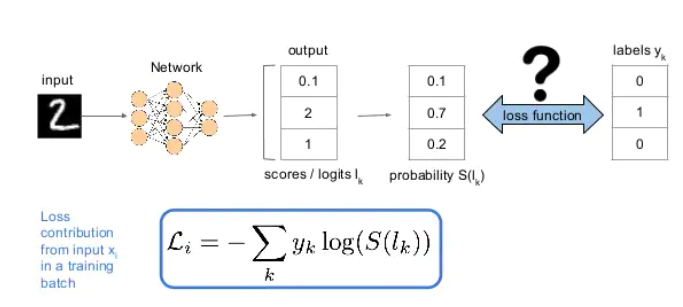

**12. Compile**
* After defining our model and stacking the layers, we have to configure our model.
* We do this configuration process in the compilation phase.
* Before training the model we need to compile it and define the loss function, optimizers, and metrics for prediction.
* We compile the model using .compile() method.

**13. Summary**
* Finally we receives a Table of all the trainable parameters per layer.
* We Receive type and shape of all layers.
* A total number of parameter.

In [6]:
model = Sequential()

# 1 - Convolution
model.add(Conv2D(128,(3,3), padding='same', input_shape=(128, 128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 6th Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 7th Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 3rd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(38, activation='softmax'))

opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        2

**1. Training**
* One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
* steps per Epoch are the total number batches we get from our training dataset.
* validation steps are number of batches we get from validation/test dataset.
* finally saving tarained model to a file, here it is,"leaf_Diseases.h5".
* **model.fit(), is our method to fit our training data in our ML Model, while learning from each epoch.**

**2. Try Run**
* This run is just an optional task to see if everything works fine.
* You can Skip this part if You Know you are doing it right.
* This is a recommended part to be performed,to see if your model fits the system architecture and no memory leaks out while training.


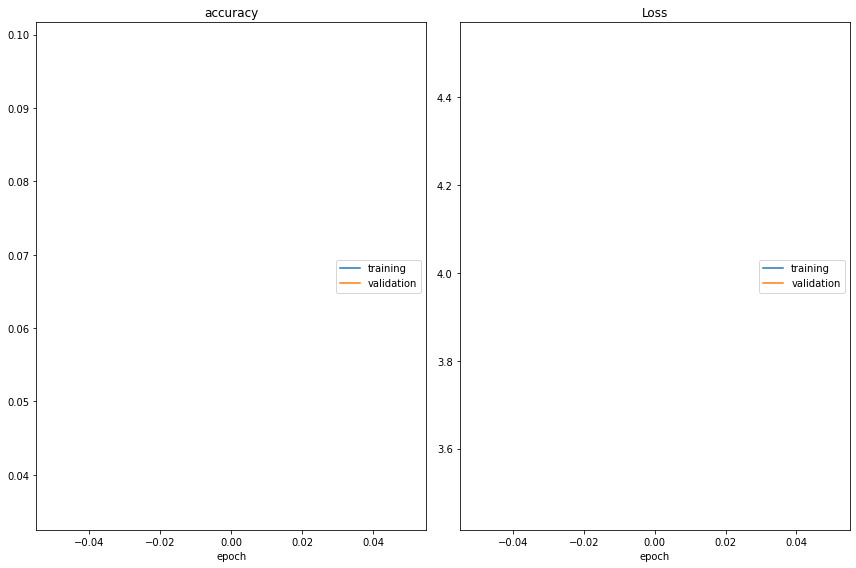

accuracy
	training         	 (min:    0.099, max:    0.099, cur:    0.099)
	validation       	 (min:    0.036, max:    0.036, cur:    0.036)
Loss
	training         	 (min:    3.468, max:    3.468, cur:    3.468)
	validation       	 (min:    4.518, max:    4.518, cur:    4.518)

Epoch 00001: saving model to /kaggle/working/leaf_Diseases.h5
CPU times: user 3min 19s, sys: 13.5 s, total: 3min 33s
Wall time: 10min 24s


In [7]:
%%time

epochs = 1
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("/kaggle/working/leaf_Diseases.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]
with tf.device('/device:GPU:0'):
  history = model.fit(
      x=train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      callbacks=callbacks
  )

**1. Main Training.**
* In this we can see accuracy and loss chart growing and descending respectively, which is a good sign.
* Differences between validation and training lines should not be large, if it is then your data is overfitted/underfitted.
* if Validation loss is greater and validation accuracy is lower then training loss then data is undertrained,underfitted.  It usually happens when we have fewer data to build an accurate model and also when we try to build a linear model with fewer non-linear data.
* WhereAs is Training loss is greater and training accuracy is lower then data is overfitted. When a model gets trained with so much data, it starts learning from the noise and inaccurate data entries in our data set

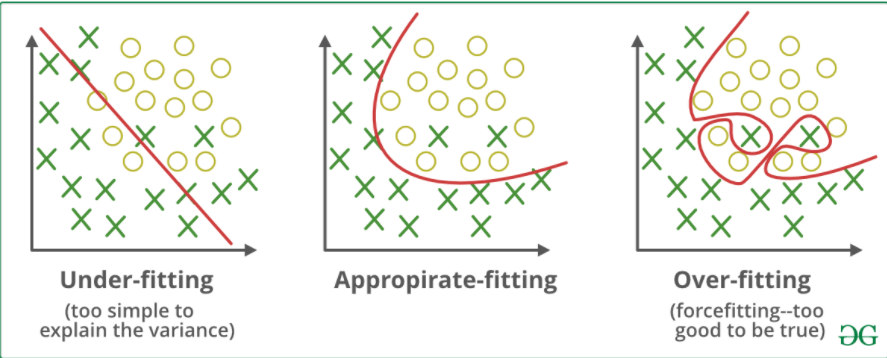



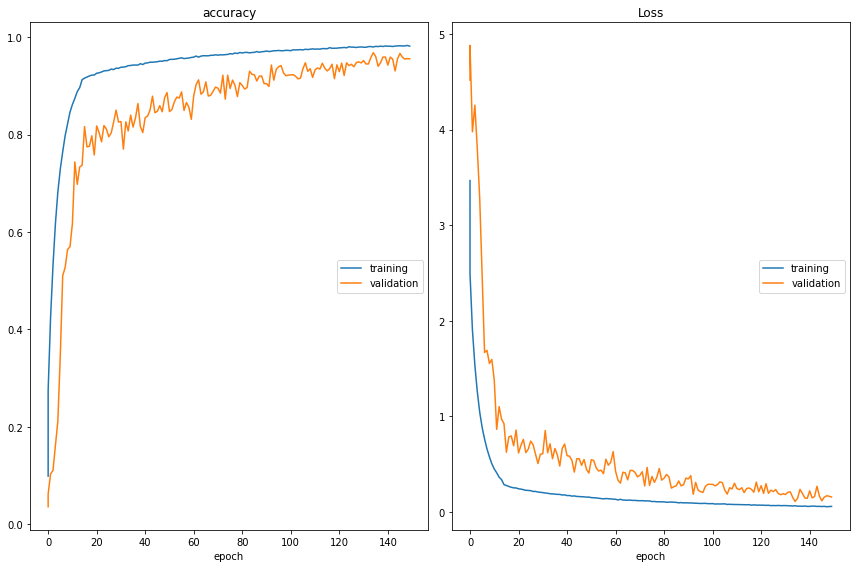

accuracy
	training         	 (min:    0.099, max:    0.983, cur:    0.982)
	validation       	 (min:    0.036, max:    0.968, cur:    0.956)
Loss
	training         	 (min:    0.054, max:    3.468, cur:    0.057)
	validation       	 (min:    0.109, max:    4.881, cur:    0.156)

Epoch 00150: saving model to /kaggle/working/leaf_Diseases.h5


In [8]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      x=train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=150,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      callbacks=callbacks
  )

# Saving Layer id's to a JSON, for loading while using it in future projects.

In [9]:
model_json = model.to_json()
with open("/kaggle/working/leaf_Diseases.json", "w") as json_file:
    json_file.write(model_json)
    
print("Execution Time: ",time.time()-start_time,"seconds");

Execution Time:  29392.05833029747 seconds


# End of Training Dataset Model For Predicting Leafs and the Name of disease it is having(if any.)

In [10]:
from tensorflow.keras.models import model_from_json
fname="/kaggle/input/leafdiseasedatasettraining/leaf_Diseases.json"
with open(fname, "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = model_from_json(loaded_model_json)
dname="/kaggle/input/leafdiseasedatasettraining/leaf_Diseases.h5"
loaded_model.load_weights(dname)